In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("houses_Madrid.csv")
#df = df.set_index(['id'])

In [3]:
df.drop(['Unnamed: 0','portal','door','are_pets_allowed','is_furnished','is_kitchen_equipped','has_private_parking','has_public_parking','has_central_heating','has_individual_heating','is_exterior'], axis=1, inplace=True)
df.drop(['is_accessible','is_buy_price_known','is_rent_price_known','rent_price_by_area','rent_price','operation','is_floor_under','street_number','street_name','is_exact_address_hidden','raw_address','subtitle','title'], axis=1, inplace=True)
df.drop(['sq_mt_allotment','is_parking_included_in_price','parking_price','sq_mt_useful','is_orientation_north','is_orientation_west','is_orientation_south','is_orientation_east','has_ac','has_fitted_wardrobes','energy_certificate'], axis=1, inplace=True)
df.drop('floor', axis=1, inplace=True)
df.dropna(subset=['sq_mt_built'], how='all', inplace=True)
df.dropna(subset=['n_bathrooms'], how='all', inplace=True) 

In [4]:
df.fillna({'n_floors': 0}, inplace=True)

In [5]:
#df['built_year'] = np.where(df['is_new_development'] == True, 2022, df['built_year'])
df.drop('is_new_development', axis=1, inplace=True)
df["built_year"] = pd.to_numeric(df["built_year"])
#df['built_year'] = np.where(df['built_year'] < 2000, 1, df['built_year'])
#df['built_year'] = np.where(df['built_year'] >= 2000, 0, df['built_year'])

In [6]:
col_liste = ['has_green_zones','has_terrace','has_balcony','has_storage_room','has_garden','has_lift','has_pool']
for col in df[col_liste]:
    df[col] = df[col].fillna('False')

In [7]:
pattern = r'Neighborhood (\d+): ([\w\s]+) \(([\d\.]+) €/m2\) - District (\d+): ([\w\s]+)'
df[['Neighborhood_number', 'nom_quartier', 'euro_m2', 'district_number', 'district']] = df['neighborhood_id'].str.extract(pattern)
df.drop(['neighborhood_id','Neighborhood_number','nom_quartier','euro_m2','district'],axis=1,inplace=True)
df.fillna({'district_number': 16}, inplace=True)

In [8]:
df.dropna(subset=['house_type_id'], how='all', inplace=True)
df.loc[df['house_type_id'].str.contains("ticos"),'house_type_id'] = 'penthouse'
df.loc[df['house_type_id'].str.contains("plex"),'house_type_id'] = 'duplex'
df.loc[df['house_type_id'].str.contains("Casa"),'house_type_id'] = 'maison'
df.loc[df['house_type_id'].str.contains("Pisos"),'house_type_id'] = 'appartement'

In [9]:
col_dict={'sq_mt_built':'m2_construit','n_rooms':'nb_pieces','n_bathrooms':'nb_sdb','n_floors':'nb_etages',
         'buy_price':'prix_achat','buy_price_by_area':'prix_achat_m2','house_type_id':'type_maison',
         'is_renewal_needed':'travaux_necessaire','built_year':'annee_construction','has_lift':'ascenseur','has_garden':'jardin',
         'has_pool':'piscine','has_terrace':'terrace','has_balcony':'balcon','has_storage_room':'salle_rangement',
         'has_green_zones':'espace_vert','has_parking':'parking','district_number':'num_quartier'}
df.rename(columns=col_dict, inplace=True)

In [10]:
df['ascenseur'] = df['ascenseur'].map({'False':False, 'True':True})
df['jardin'] = df['jardin'].map({'False':False, 'True':True})
df['piscine'] = df['piscine'].map({'False':False, 'True':True})
df['terrace'] = df['terrace'].map({'False':False, 'True':True})
df['balcon'] = df['balcon'].map({'False':False, 'True':True})
df['salle_rangement'] = df['salle_rangement'].map({'False':False, 'True':True})
df['espace_vert'] = df['espace_vert'].map({'False':False, 'True':True})

df=df.astype({"m2_construit":int, "nb_sdb":int, 'nb_sdb':int, 'nb_etages':int, 'ascenseur':bool,
          'jardin':bool, 'piscine':bool, 'terrace':bool, 'balcon':bool, 'salle_rangement':bool, 'espace_vert':bool,
          'num_quartier':int})

In [11]:
df = df[df['nb_pieces'] >= 1]
df = df[df['nb_sdb'] <= 6]
df = df[df['prix_achat'] <= 1750000]
df = df[df['prix_achat_m2'] <= 10000]
df = df[df['m2_construit'] <= 300]
df.fillna({'annee_construction': 2077}, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18515 entries, 0 to 21741
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  18515 non-null  int64  
 1   m2_construit        18515 non-null  int64  
 2   nb_pieces           18515 non-null  int64  
 3   nb_sdb              18515 non-null  int64  
 4   nb_etages           18515 non-null  int64  
 5   latitude            0 non-null      float64
 6   longitude           0 non-null      float64
 7   prix_achat          18515 non-null  int64  
 8   prix_achat_m2       18515 non-null  int64  
 9   type_maison         18515 non-null  object 
 10  travaux_necessaire  18515 non-null  bool   
 11  annee_construction  18515 non-null  float64
 12  ascenseur           18515 non-null  bool   
 13  jardin              18515 non-null  bool   
 14  piscine             18515 non-null  bool   
 15  terrace             18515 non-null  bool   
 16  balcon   

In [13]:
conditions = [
    df['num_quartier'] == 1,
    df['num_quartier'] == 2,
    df['num_quartier'] == 3,
    df['num_quartier'] == 4,
    df['num_quartier'] == 5,
    df['num_quartier'] == 6,
    df['num_quartier'] == 7,
    df['num_quartier'] == 8,
    df['num_quartier'] == 9,
    df['num_quartier'] == 10,
    df['num_quartier'] == 11,
    df['num_quartier'] == 12,
    df['num_quartier'] == 13,
    df['num_quartier'] == 14,
    df['num_quartier'] == 15,
    df['num_quartier'] == 16,
    df['num_quartier'] == 17,
    df['num_quartier'] == 18,
    df['num_quartier'] == 19,
    df['num_quartier'] == 20,
    df['num_quartier'] == 21,
    ]


lat = [41.626817,40.396954,40.41115,40.427045,40.458987,40.460578,40.438962,40.426274,40.43502,40.403532,40.374211,40.383894,40.38686,
       40.405933,40.448431,40.472549,40.34561,40.373958,40.401838,40.4165,40.473318]
long =[-4.72699,-3.697289,-3.676057,-3.680602,-3.676129,-3.698281,-3.705302,-3.700907,-3.719236,-3.736152,-3.744676,-3.706446,-3.704446,
      -3.65918,-3.644874,-3.642551,-3.695956,-3.612163,-3.595054,-3.70256,-3.579845]

df['latitude'] = np.select(conditions, lat)
df['longitude'] = np.select(conditions, long)


In [14]:
df1=df.astype({"m2_construit":int, "nb_sdb":int, 'nb_sdb':int, 'nb_etages':int, 'ascenseur':int,
          'jardin':int, 'piscine':int, 'terrace':int, 'balcon':int, 'salle_rangement':int, 'espace_vert':int,
          'num_quartier':int,'travaux_necessaire':int,'parking':int})

In [15]:
df1.to_csv('houses_Madrid_clean.csv', index=False)

In [16]:
df = pd.get_dummies(df, prefix=['type'], columns=['type_maison'])#,drop_first=True)
df.drop(['id','latitude','longitude'], axis=1, inplace=True)

In [17]:
df_annee = df[df['annee_construction'] > 1950]
df_annee = df_annee[df_annee['annee_construction'] <= 2024]

data = df_annee.drop('annee_construction', axis=1)

target = df_annee['annee_construction']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

In [18]:
model_en = ElasticNetCV(cv=5, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),max_iter=10000)

model_en.fit(X_train, y_train)
print('')

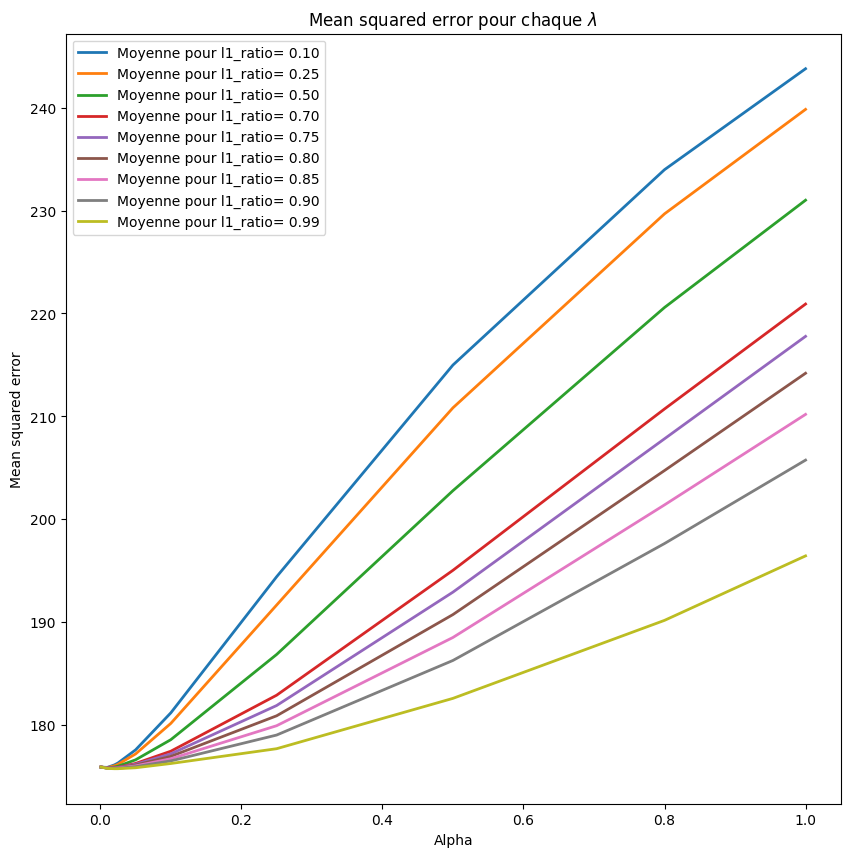

In [19]:
alphas = model_en.alphas_

plt.figure(figsize=(10, 10))

for i in range(model_en.mse_path_.shape[0]) :
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();

In [20]:
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print(np.sqrt(mean_squared_error(y_train, pred_train)))
print(np.sqrt(mean_squared_error(y_test, pred_test)))

13.192367923915837
12.92908173888541


In [21]:
print('score train :', model_en.score(X_train, y_train))
print('score test :', model_en.score(X_test, y_test))

score train : 0.5032181213544433
score test : 0.514952587385076


In [22]:
pd.DataFrame({'points_observés': y_test, 'points_predits' : np.round(pred_test)}, 
             index=X_test.index).head(7)

,points_observés,points_predits
4386,1998.0,1991.0
5619,1990.0,1976.0
2421,1960.0,1976.0
16745,1980.0,1974.0
12302,1964.0,1972.0
3603,2008.0,1995.0
12237,1980.0,1980.0


In [23]:
model_final = ElasticNetCV(cv=5, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),max_iter=10000)

model_final.fit(data, target)
print('')

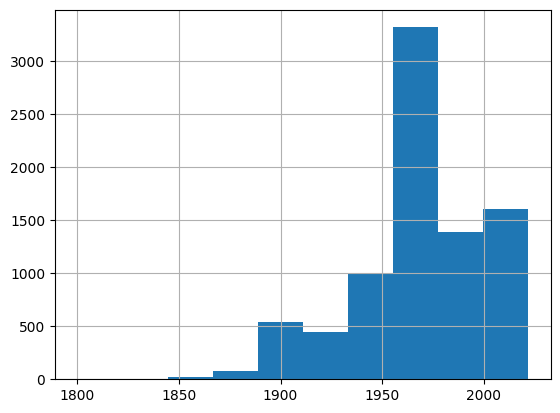

In [24]:
df.loc[df['annee_construction'] <= 2024].annee_construction.hist();

In [25]:
df['predict'] = model_final.predict(df.drop('annee_construction', axis=1))
df=df.astype({"predict":int})
df.loc[df['annee_construction'] >= 2024,'annee_construction'] = df.loc[df['annee_construction'] >= 2024, 'predict']
df=df.drop(['predict'],axis=1)

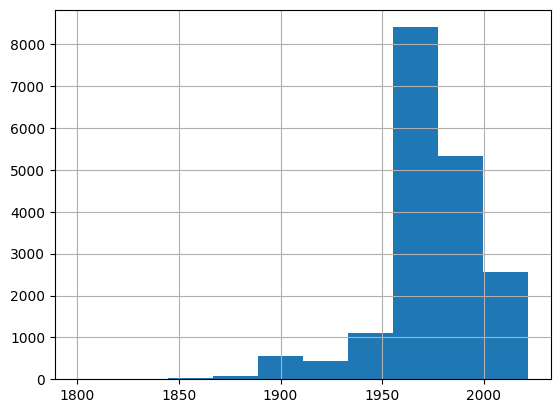

In [26]:
df.annee_construction.hist();

In [27]:
data = df.drop('prix_achat', axis=1)
target = df['prix_achat']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

model_en = ElasticNetCV(cv=5, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),max_iter=100000)

model_en.fit(X_train, y_train)

pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print(np.sqrt(mean_squared_error(y_train, pred_train)))
print(np.sqrt(mean_squared_error(y_test, pred_test)))

82783.63000014592
80185.64103752126


In [28]:
print('score train :', model_en.score(X_train, y_train))
print('score test :', model_en.score(X_test, y_test))

score train : 0.9372803081329948
score test : 0.9385594575585813


In [29]:
pd.DataFrame({'points_observés': y_test, 'points_predits' : np.round(pred_test)}, 
             index=X_test.index).head(7)

,points_observés,points_predits
14727,559000,591854.0
9924,539600,560126.0
509,159000,131724.0
13909,425000,456051.0
1642,199500,172869.0
16147,138000,86439.0
9023,700000,798021.0


In [30]:
str(int(100*np.sqrt(mean_squared_error(y_test, pred_test))/df['prix_achat'].mean()))+'%'

'18%'